{'11': 106, '01': 413, '00': 123, '10': 358}


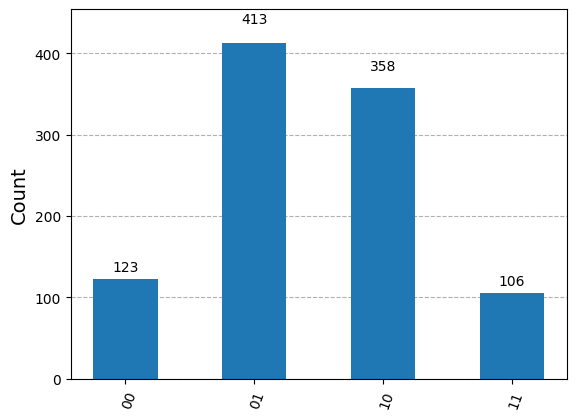

In [ ]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator  # AerSimulatorを使用
from qiskit.visualization import plot_histogram
import numpy as np

'''
説明:
量子振幅増幅は、ある「望ましい状態（正解）」の振幅（確率）を増やし、それを測定によって高確率で得られるようにするテクニックです。
以下の2つの操作を セットで1回の「反復（iteration）」 とみなします：
・オラクル（振幅反転）
   正解の状態だけ位相（振幅の符号）を反転
・拡散操作（反射操作）
   状態全体を「平均値から反転」させることで、正解状態の振幅が増加する

4π*√N回の繰り返しが必要なことが知られています。
例：
問題サイズN=4(2量子ビット)→約1回
問題サイズN=8(3量子ビット)→約2回
問題サイズN=16(4量子ビット)→約3回
'''


################################
#### オラクル（振幅反転）と 拡散操作（反射操作）が１回の単純な実装
################################


# ################
# # 量子レジスタの作成
# ################
# qr_amp = QuantumRegister(2, name='amp')
# circuit = QuantumCircuit(qr_amp)

# ################
# # 初期状態 A
# ################
# circuit.ry(2*np.pi/3, 0)
# circuit.h(1)
# circuit.cx(1, 0)
# # ここは、初期状態 
# # ∣𝜓⟩=𝐴∣00⟩を作っています。
# # 特に ry(2π/3) によって、量子ビット0がある程度「正解状態の重ね合わせ」に寄るように設計されています。

# # h(1) で量子ビット1を均等な重ね合わせにして、cx(1,0) でエンタングルメントを作ってます。

# ################
# # 振幅増幅
# ################

# # オラクル的な変換 𝑈𝜓（振幅反転）
# # UΨ_0
# circuit.x(0)
# circuit.z(0)
# circuit.z(1)
# circuit.x(0)
# # このオラクルは、"01"を「正解」としてマークしています。
# # 正解状態に「符号反転」（phase flip）を加える操作です。
# # ∣𝑥⟩→−∣𝑥⟩ を正解のみに適用することで、その振幅だけがマイナスになります。
# # この部分が「オラクル（Oracle）」の役割を担っています。




# # 反射操作（Diffusion-like）
# # UΨ: 「平均からの反転」
# circuit.cx(1, 0)
# circuit.h(1)
# circuit.ry(-2*np.pi/3, 0)

# circuit.x([0, 1])
# circuit.cz(0, 1)
# circuit.x([0, 1])

# circuit.ry(2*np.pi/3, 0)
# circuit.h(1)
# circuit.cx(1, 0)

# # これは「平均値からの反転（reflection about the mean）」をする操作で、Groverの「拡散変換」に対応します。
# # 通常のGroverでは H → X → CZ → X → H のような形になりますが、ここでは RY で初期状態が作られているため、
# # それに合わせた「逆操作（反転）」と「再度の操作（再構築）」が行われています。



################################
#### オラクル（振幅反転）と 拡散操作（反射操作）を複数回行う場合の実装
################################


# === 関数定義 ===

# オラクル（特定の状態の振幅にマイナス符号をつける）
def apply_oracle(circuit, qr):
    circuit.x(qr[0])
    circuit.z(qr[0])
    circuit.z(qr[1])
    circuit.x(qr[0])
'''
このオラクルは、"01"を「正解」としてマークしています。
x(qr[0]) → ビット0が反転
z(qr[0]) → ビット0にZ（符号反転）
z(qr[1]) → ビット1にZ
x(qr[0]) → ビット0を再び元に戻す
'''

# 拡散（平均からの反転操作）
def apply_reflection(circuit, qr):
    # 逆の初期化（=初期状態からの反射）をする
    circuit.cx(qr[1], qr[0])
    circuit.h(qr[1])
    circuit.ry(-2*np.pi/3, qr[0])

    circuit.x([qr[0], qr[1]])
    circuit.cz(qr[0], qr[1])
    circuit.x([qr[0], qr[1]])

    circuit.ry(2*np.pi/3, qr[0])
    circuit.h(qr[1])
    circuit.cx(qr[1], qr[0])

# === メイン回路構築 ===

# 量子レジスタ作成
qr_amp = QuantumRegister(2, name='amp')
circuit = QuantumCircuit(qr_amp)

# 初期状態の準備 A|00⟩
circuit.ry(2*np.pi/3, qr_amp[0])
circuit.h(qr_amp[1])
circuit.cx(qr_amp[1], qr_amp[0])

# 振幅増幅の繰り返し回数（今回は2回）
k = 2
for _ in range(k):
    apply_oracle(circuit, qr_amp)
    apply_reflection(circuit, qr_amp)



################
#### 測定
################
circuit.measure_all()

################
#### AerSimulatorを使用したシミュレーション
################
simulator = AerSimulator()
compiled_circuit = transpile(circuit, simulator)
result = simulator.run(compiled_circuit, shots=1000).result()

################
#### 結果の取得と表示
################
answer = result.get_counts(circuit)
print(answer)
plot_histogram(answer)




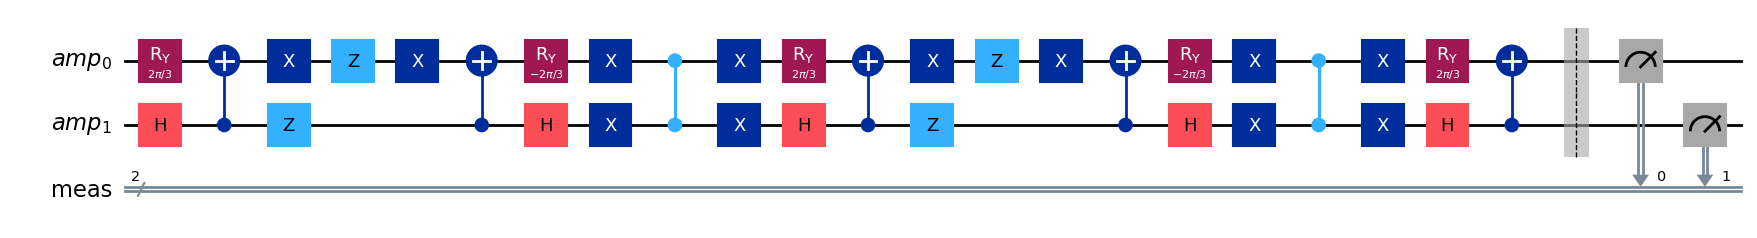

In [7]:
################
#### 回路図を描画
################
circuit.draw(output='mpl')